<a href="https://colab.research.google.com/github/ypeng12/Airline/blob/main/AirlineGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sort the time

get the csv and got the total time for the flight

In [38]:
import pandas as pd
import os

def group_flights_by_interval(file_path, interval_minutes):
    # Extract the name from the file path
    file_name = os.path.basename(file_path).split('_')[0]

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert 'Sched.' to datetime and extract the time in minutes
    df['Sched.'] = pd.to_datetime(df['Sched.'], format='%H:%M', errors='coerce')
    df['Minutes'] = df['Sched.'].dt.hour * 60 + df['Sched.'].dt.minute

    # Calculate the interval bin for each flight
    df['Interval'] = (df['Minutes'] // interval_minutes) * interval_minutes

    # Create a column for the exact interval time
    df['Interval Time'] = pd.to_datetime(df['Interval'], unit='m').dt.strftime('%H:%M')

    # Group by the interval time and count the number of flights
    grouped_flights = df.groupby('Interval Time').size().reset_index(name=file_name)

    return grouped_flights

def process_all_files(directory_path, interval_minutes, output_file):
    all_data = None

    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            grouped_flights = group_flights_by_interval(file_path, interval_minutes)
            if all_data is None:
                all_data = grouped_flights
            else:
                all_data = pd.merge(all_data, grouped_flights, on='Interval Time', how='outer')

    # Fill NaN values with 0 and save the combined data to a CSV file
    all_data = all_data.fillna(0)
    all_data.to_csv(output_file, index=False)

# Example usage
directory_path = '/mnt/hawaii'  # Adjust this to your actual directory path
output_file = '/mnt/data/flight_status.csv'  # Adjust this to your desired output file path
interval_minutes = 30  # Set this to the desired interval in minutes

# Process all files and save the combined data
process_all_files(directory_path, interval_minutes, output_file)

print(f"Combined flight data saved to: {output_file}")


Combined flight data saved to: /mnt/data/flight_status.csv


got the file in data and could change by type the int


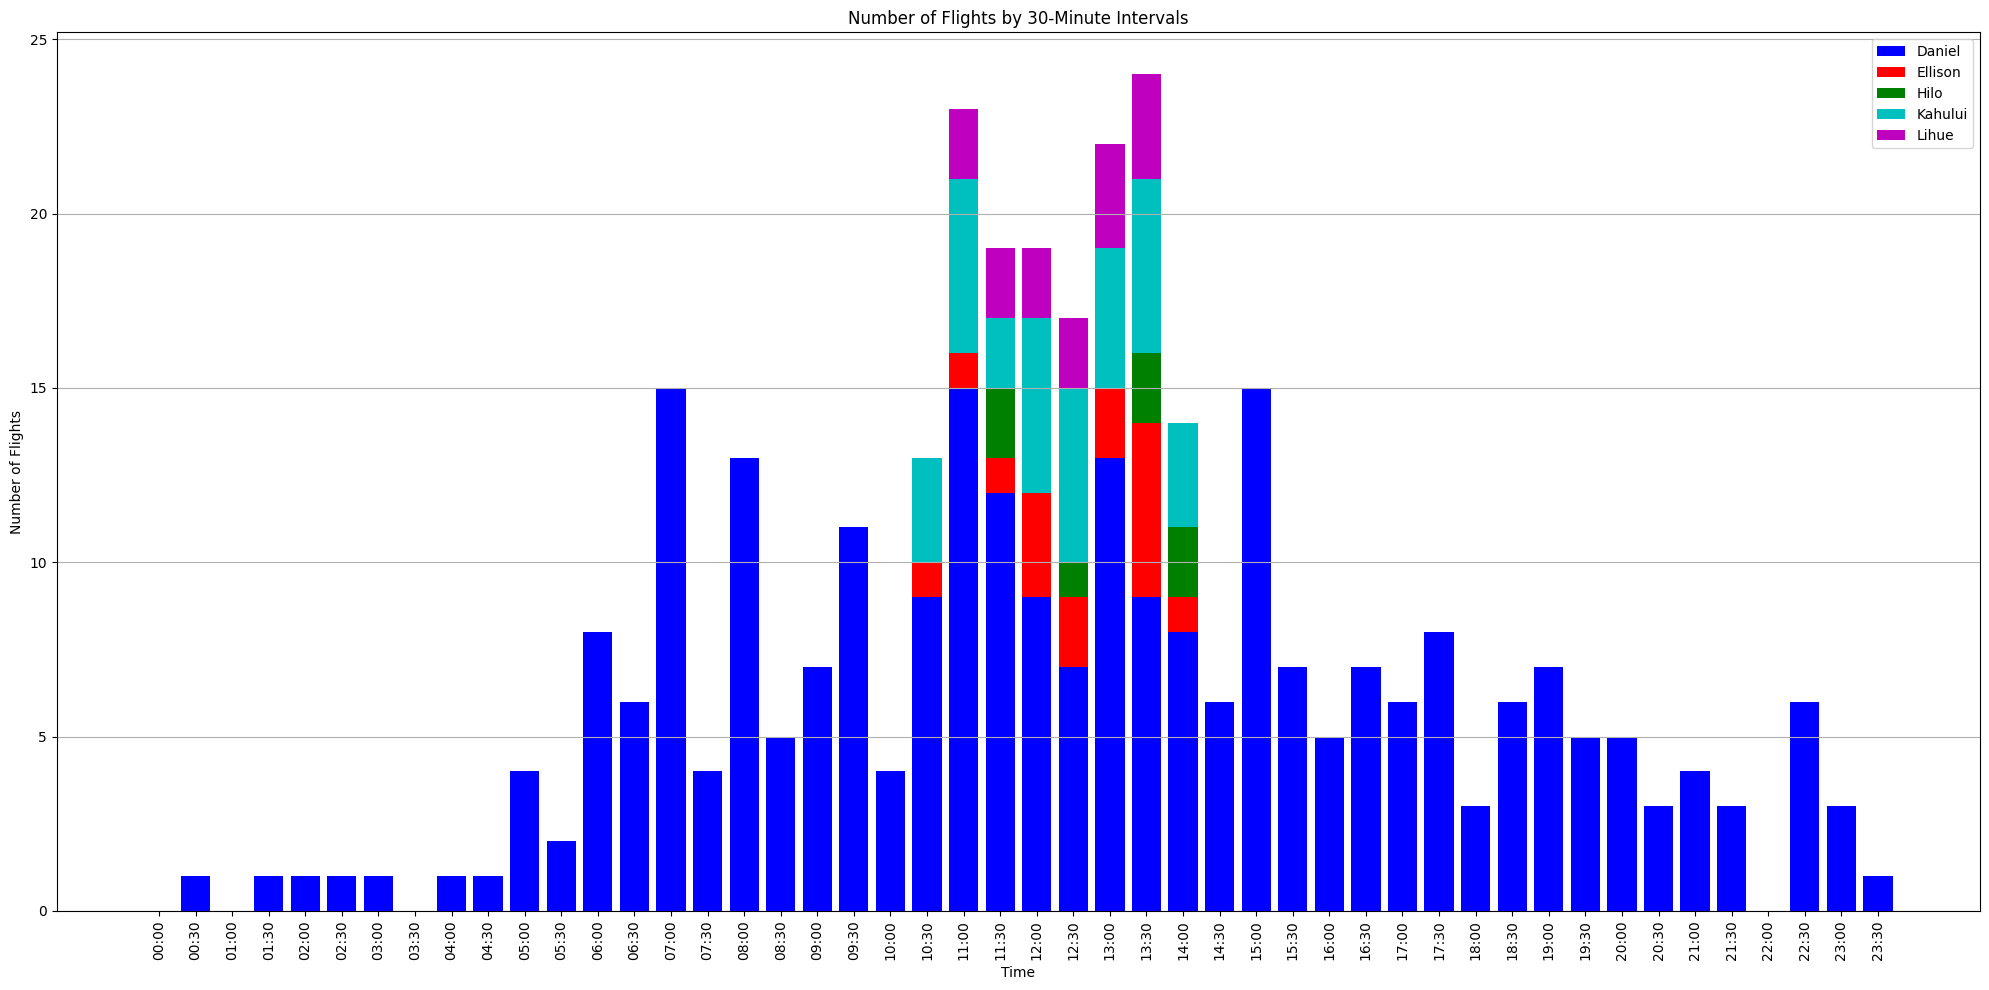

In [45]:

# Load the combined data for plotting
grouped_file_path = output_file
grouped_flights = pd.read_csv(grouped_file_path)

# Ensure 'Interval Time' is treated as a string for plotting
grouped_flights['Interval Time'] = pd.to_datetime(grouped_flights['Interval Time'], format='%H:%M')

# Generate a complete range of intervals for the day
# Need to change the time zone
time_range = pd.date_range(start='00:00', end='23:59', freq='30T').strftime('%H:%M')
complete_range = pd.DataFrame(time_range, columns=['Interval Time'])

# Convert 'Interval Time' in both DataFrames to string for merging
grouped_flights['Interval Time'] = grouped_flights['Interval Time'].dt.strftime('%H:%M')

# Merge this complete range with the flight data
merged_flights = complete_range.merge(grouped_flights, on='Interval Time', how='left').fillna(0)

# Convert flight count columns to integer, excluding the 'Interval Time' column
flight_count_columns = merged_flights.columns.difference(['Interval Time'])
merged_flights[flight_count_columns] = merged_flights[flight_count_columns].astype(int)

# Plot the data
plt.figure(figsize=(20, 10))

# Plotting the stacked bar chart
bottom = None
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Define colors for each airport

for idx, column in enumerate(flight_count_columns):
    if bottom is None:
        plt.bar(merged_flights['Interval Time'], merged_flights[column], color=colors[idx % len(colors)], label=column)
        bottom = merged_flights[column]
    else:
        plt.bar(merged_flights['Interval Time'], merged_flights[column], bottom=bottom, color=colors[idx % len(colors)], label=column)
        bottom += merged_flights[column]

# Add title and labels
plt.title('Number of Flights by 30-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Flights')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ticks=range(0, len(merged_flights), 1))

# Add grid for better readability
plt.grid(axis='y')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()